In [1]:
import pandas as pd
import re as re
import numpy as np

df = pd.read_csv('data/booksummaries.txt',sep='\t', names = ["Wiki ID", "Freebase ID", "Title", "Author", "Publication Date", "Genres", "Summary" ])

In [2]:
df.head()

,Wiki ID,Freebase ID,Title,Author,Publication Date,Genres,Summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [3]:
df = df[['Title', 'Genres', 'Summary']]

In [4]:
df.isnull().sum()

Title         0
Genres     3718
Summary       0
dtype: int64

In [5]:
df.dropna(subset=['Genres'], inplace=True)

In [6]:
df.isnull().sum()

Title      0
Genres     0
Summary    0
dtype: int64

In [7]:
df.shape

(12841, 3)

In [8]:
print(df.loc[[0]])

         Title                                             Genres  \
0  Animal Farm  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   

                                             Summary  
0   Old Major, the old boar on the Manor Farm, ca...  


In [9]:
df.Genres[0]

'{"/m/016lj8": "Roman \\u00e0 clef", "/m/06nbt": "Satire", "/m/0dwly": "Children\'s literature", "/m/014dfn": "Speculative fiction", "/m/02xlf": "Fiction"}'

In [10]:
type(df.Genres[0])

str

In [11]:
import json
type(json.loads(df['Genres'][0]))

dict

In [12]:
json.loads(df['Genres'][0]).values()

dict_values(['Roman à clef', 'Satire', "Children's literature", 'Speculative fiction', 'Fiction'])

In [13]:
# Create new list for genres
genres = []

# extract genres
for i in df['Genres']: 
  genres.append(list(json.loads(i).values())) 

# add to 'genres' dataframe  
df['Genres'] = genres

In [14]:
# get all genre tags in a list

all_genres = sum(genres,[])
len(set(all_genres))

227

In [15]:
import nltk
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [16]:
all_genres_df.head()

,Genre,Count
0,Roman à clef,29
1,Satire,123
2,Children's literature,2122
3,Speculative fiction,4314
4,Fiction,4747


In [17]:
all_genres_df.sort_values(by='Count', ascending = False)

,Genre,Count
4,Fiction,4747
3,Speculative fiction,4314
5,Science Fiction,2870
10,Novel,2463
12,Fantasy,2413
...,...,...
187,Fable,1
188,Bangsian fantasy,1
189,Space western,1
194,Fantastique,1


In [18]:
print(all_genres_df['Genre'][0])

Roman à clef


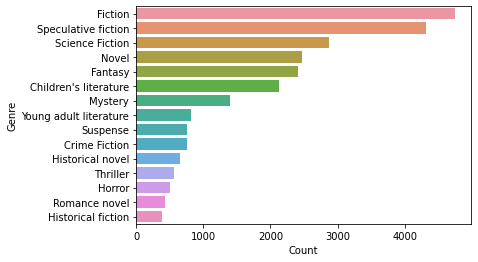

In [19]:
import matplotlib.pyplot as plt 
import seaborn as sns

g = all_genres_df.nlargest(columns="Count", n = 15) 
plt.figure() 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Genre') 
plt.show()

In [20]:
all_genres_df = all_genres_df.to_dict()

In [21]:
low_freq = []
for i in range(len(all_genres_df['Count'])):
    if all_genres_df['Count'][i] <= 50:
        low_freq.append(all_genres_df['Genre'][i])


In [22]:
len(low_freq)

189

In [23]:
df = df.reset_index(drop=True)

In [24]:
df.head()

,Title,Genres,Summary
0,Animal Farm,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
2,The Plague,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...
3,A Fire Upon the Deep,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...
4,All Quiet on the Western Front,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge..."


In [25]:
index_delete = []
for word in low_freq:
    for i in range(len(df.Genres)):
        if word in df.Genres[i]:
            if i not in index_delete:
                index_delete.append(i)        

In [26]:
df.drop(index_delete , inplace=True)

In [27]:
df.shape

(11283, 3)

In [28]:
df.head()

,Title,Genres,Summary
1,A Clockwork Orange,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
6,Blade Runner 3: Replicant Night,"[Science Fiction, Speculative fiction]","Living on Mars, Deckard is acting as a consul..."
7,Blade Runner 2: The Edge of Human,"[Science Fiction, Speculative fiction]",Beginning several months after the events in ...
9,Crash,"[Speculative fiction, Fiction, Novel]",The story is told through the eyes of narrato...
10,Children of Dune,"[Science Fiction, Speculative fiction, Childre...",Nine years after Emperor Paul Muad'dib walked...


In [29]:
df = df.reset_index(drop=True)

In [30]:
# Create new list for genres
genres = []

# extract genres
for i in range(len(df['Genres'])): 
  genres.append(df['Genres'][i]) 

In [31]:
# get all genre tags in a list

all_genres = sum(genres,[])
len(set(all_genres))

38

In [32]:
import nltk
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [33]:
all_genres_df.head()

,Genre,Count
0,Science Fiction,2615
1,Novella,73
2,Speculative fiction,3893
3,Utopian and dystopian fiction,52
4,Satire,82


In [34]:
all_genres_df = all_genres_df.sort_values(by='Count', ascending = False)
all_genres_df = all_genres_df.reset_index(drop=True)

In [35]:
df.Summary[0][:300]

' Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random "ultra-violence." Alex\'s friends ("droogs" in the novel\'s Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang\'s muscle; Georgie, an ambitious second-in-command; and Pet'

In [36]:
from nltk.corpus import stopwords
def clean_text(text):
    
    # change all letters to lower case
    text = text.lower()
    
    # remove all numbers from text
    text = re.sub(r'\d+', '', text)
    
    # remove all white spaces from text
    text = text.strip()
    
    # remove all punctuation from text
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    return text

In [37]:
import string
df['Summary'] = df['Summary'].apply(lambda x: clean_text(x))

In [38]:
df.Summary[0][:300]

'alex a teenager living in nearfuture england leads his gang on nightly orgies of opportunistic random ultraviolence alexs friends droogs in the novels anglorussian slang nadsat are dim a slowwitted bruiser who is the gangs muscle georgie an ambitious secondincommand and pete who mostly plays along a'

In [39]:
word_freq = df.Summary.str.split(expand=True).stack().value_counts().rename_axis('Word').reset_index(name='Frequency')

In [40]:
word_freq.head()

,Word,Frequency
0,the,341480
1,to,173240
2,and,165964
3,of,133069
4,a,127906


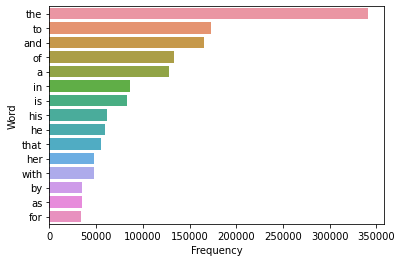

In [41]:
g = word_freq.nlargest(columns="Frequency", n = 15) 
plt.figure() 
ax = sns.barplot(data=g, x= "Frequency", y = "Word") 
ax.set(ylabel = 'Word') 
plt.show()

In [42]:
from nltk.tokenize import word_tokenize

def remove_stopwords(text):
    # cache stopwords to run faster
    cachedStopWords = stopwords.words("english")   
    
    text_tokens = word_tokenize(text)
    
    # remove all stopwords
    text = [word for word in text_tokens if word not in cachedStopWords]
    text = ' '.join(text)
    
    return text

df['Summary'] = df['Summary'].apply(lambda x: remove_stopwords(x))

In [43]:
df.Summary[0][:300]

'alex teenager living nearfuture england leads gang nightly orgies opportunistic random ultraviolence alexs friends droogs novels anglorussian slang nadsat dim slowwitted bruiser gangs muscle georgie ambitious secondincommand pete mostly plays along droogs indulge taste ultraviolence characterized so'

In [44]:
new_word_freq = df.Summary.str.split(expand=True).stack().value_counts().rename_axis('Word').reset_index(name='Frequency')

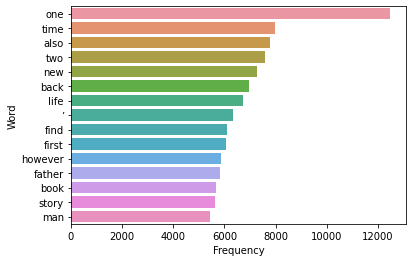

In [45]:
g = new_word_freq.nlargest(columns="Frequency", n = 15) 
plt.figure() 
ax = sns.barplot(data=g, x= "Frequency", y = "Word") 
ax.set(ylabel = 'Word') 
plt.show()

In [46]:
df.to_csv('data/clean_data.csv', index = False)

In [47]:
new_word_freq.shape

(120376, 2)

In [48]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['Genres'])

# transform target variable
y = multilabel_binarizer.transform(df['Genres'])

In [49]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0])

In [50]:
all_genres_df['Count'][0]/len(df.Genres) # No. Fiction books / All books

0.3714437649561287

In [51]:
from sklearn.model_selection import train_test_split

# split data in train and test set:
x_train, x_test, y_train, y_test = train_test_split(df['Summary'], y, test_size=0.2, random_state=1)

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=8000)

# create TF-IDF features

x_train_vec = tfidf_vectorizer.fit_transform(x_train).astype('float32')
x_test_vec = tfidf_vectorizer.transform(x_test).astype('float32')

In [53]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
rd = RandomForestClassifier()
clf = OneVsRestClassifier(rd)

# fit model on train data

clf.fit(x_train_vec, y_train)

# make predictions for validation set
y_pred = clf.predict(x_test_vec)

print('f1 score (RD): ', f1_score(y_test, y_pred, average="micro"))

f1 score (RD):  0.31562401760452685


In [73]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

# fit model on train data

clf.fit(x_train_vec, y_train)

# make predictions for validation set
y_pred = clf.predict(x_test_vec)

print('f1 score (LR): ',f1_score(y_test, y_pred, average = 'micro'))

f1 score (LR):  0.3845584972637183


In [57]:
y_pred_prob = clf.predict_proba(x_test_vec)
y_pred_new = (y_pred_prob >= 0.3).astype(int)
print('f1 score (LR with 0.3 threshold)', f1_score(y_test, y_pred_new, average="micro"))

f1 score (LR with 0.3 threshold) 0.5607050285121825


In [58]:
multilabel_binarizer.inverse_transform(y_pred_new)[0]

('Fiction', 'Science Fiction', 'Speculative fiction')

In [59]:
multilabel_binarizer.inverse_transform(y)[0]

('Fiction',
 'Novella',
 'Satire',
 'Science Fiction',
 'Speculative fiction',
 'Utopian and dystopian fiction')

In [61]:
from keras.utils import to_categorical

y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

In [62]:
from keras.preprocessing.text import Tokenizer

tk = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
tk.fit_on_texts(x_train)

x_train_new = tk.texts_to_sequences(x_train)
tk.fit_on_texts(x_test)

x_test_new = tk.texts_to_sequences(x_test)

In [63]:
from keras.preprocessing import sequence
x_train_new = sequence.pad_sequences(x_train_new, maxlen= 500, padding='pre')
x_test_new = sequence.pad_sequences(x_test_new, maxlen= 500, padding='pre')

In [64]:
max_features = len(tk.word_index) + 1

In [65]:
def build_model():
    embedding_vector_length = 32
    model = Sequential()
    model.add(Embedding(max_features, embedding_vector_length, input_length=500))
    model.add(Flatten())
    model.add(Dense(38, activation='relu'))
    model.add(Dense(38, activation='relu'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [66]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten

In [101]:
model = build_model()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 32)           3852064   
_________________________________________________________________
flatten_7 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 38)                608038    
_________________________________________________________________
dense_14 (Dense)             (None, 38)                1482      
Total params: 4,461,584
Trainable params: 4,461,584
Non-trainable params: 0
_________________________________________________________________
None


In [93]:
x_train_g = x_train_new[:1000]
y_train_g = y_train[:1000]

model2 = KerasClassifier(build_fn=build_model, verbose=0)
batch_size = [25, 30, 50]
epochs = [2, 4, 6]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(x_train_g[:800], y_train_g[:800], validation_data=(x_train_g[800:], y_train_g[800:]))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           3852064   
_________________________________________________________________
flatten_6 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 38)                608038    
_________________________________________________________________
dense_12 (Dense)             (None, 38)                1482      
Total params: 4,461,584
Trainable params: 4,461,584
Non-trainable params: 0
_________________________________________________________________
None
Best: 0.940724 using {'batch_size': 25, 'epochs': 2}
0.940724 (0.001053) with: {'batch_size': 25, 'epochs': 2}
0.936349 (0.003322) with: {'batch_size': 25, 'epochs': 4}
0.940724 (0.001053) with: {'batch_size': 25, 'epochs': 6}
0.940724 (

In [102]:
final_model = model.fit(x_train_new, y_train, validation_data=(x_test_new, y_test), epochs=2, batch_size=25)

Train on 9026 samples, validate on 2257 samples
Epoch 1/2
9026/9026 [==============================] - 12s 1ms/step - loss: 0.3027 - accuracy: 0.9400 - val_loss: 0.2666 - val_accuracy: 0.9417
Epoch 2/2
9026/9026 [==============================] - 12s 1ms/step - loss: 0.2396 - accuracy: 0.9414 - val_loss: 0.2337 - val_accuracy: 0.9417


[]

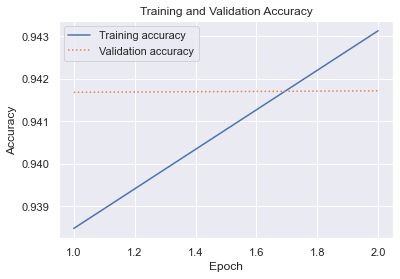

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()

In [107]:
y_pred = model.predict(x_test_new)
y_class = model.predict_classes(x_test_new)


In [106]:
y_pred[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11375162, 0.        , 0.        , 0.07025838,
       0.        , 0.01002889, 0.09487514, 0.24738148, 0.        ,
       0.        , 0.04012751, 0.05536854, 0.        , 0.03939748,
       0.        , 0.        , 0.08135166, 0.        , 0.17428659,
       0.        , 0.        , 0.        , 0.17214702, 0.        ,
       0.22657114, 0.        , 0.0358769 , 0.        , 0.07299057,
       0.        , 0.        , 0.13347296], dtype=float32)

In [112]:
# Print results.
print('Validation accuracy: {acc}, loss: {loss}'.format(
    acc=final_model.history['val_accuracy'][-1], loss=final_model.history['val_loss'][-1]))

Validation accuracy: 0.9416900873184204, loss: 0.23374808819673207


In [131]:
predictions = multilabel_binarizer.inverse_transform([np.argmax(pred) for pred in y_pred])

AttributeError: 'list' object has no attribute 'shape'

In [132]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0])

In [134]:
y.inverse_transform(y[0])

AttributeError: 'numpy.ndarray' object has no attribute 'inverse_transform'

In [138]:
multilabel_binarizer.inverse_transform(y)[0]

('Fiction',
 'Novella',
 'Satire',
 'Science Fiction',
 'Speculative fiction',
 'Utopian and dystopian fiction')

In [129]:
y_pred[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11375162, 0.        , 0.        , 0.07025838,
       0.        , 0.01002889, 0.09487514, 0.24738148, 0.        ,
       0.        , 0.04012751, 0.05536854, 0.        , 0.03939748,
       0.        , 0.        , 0.08135166, 0.        , 0.17428659,
       0.        , 0.        , 0.        , 0.17214702, 0.        ,
       0.22657114, 0.        , 0.0358769 , 0.        , 0.07299057,
       0.        , 0.        , 0.13347296], dtype=float32)

In [171]:
np.argmax(y_pred[0])

13

In [139]:
y_pred[0][13]

0.24738148

In [164]:
array = [0] * 38
array[int(np.argmax(y_pred[0]))] = 1
array = np.array(array, dtype = 'float32')

In [167]:
multilabel_binarizer.inverse_transform(array)

IndexError: tuple index out of range

In [166]:
array

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32)

In [169]:
multilabel_binarizer.inverse_transform(y)

[('Fiction',
  'Novella',
  'Satire',
  'Science Fiction',
  'Speculative fiction',
  'Utopian and dystopian fiction'),
 ('Science Fiction', 'Speculative fiction'),
 ('Science Fiction', 'Speculative fiction'),
 ('Fiction', 'Novel', 'Speculative fiction'),
 ("Children's literature",
  'Fiction',
  'Science Fiction',
  'Speculative fiction'),
 ("Children's literature",
  'Fiction',
  'Science Fiction',
  'Speculative fiction'),
 ('Gothic fiction',),
 ('Fiction',),
 ("Children's literature",
  'Fiction',
  'Novel',
  'Science Fiction',
  'Speculative fiction'),
 ('Fiction',),
 ("Children's literature",
  'Dystopia',
  'Fiction',
  'Science Fiction',
  'Speculative fiction',
  'Utopian and dystopian fiction'),
 ('Fantasy', 'Fiction'),
 ('Detective fiction', 'Fiction', 'Mystery', 'Novel', 'Suspense'),
 ("Children's literature",
  'Fiction',
  'Science Fiction',
  'Speculative fiction'),
 ('Fiction', 'Historical fiction', 'Novel'),
 ('Fiction', 'Science Fiction', 'Speculative fiction'),
 ('A

In [172]:
y_pred2 = model.predict_proba(x_test_new)

In [173]:
y_pred2[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11375162, 0.        , 0.        , 0.07025838,
       0.        , 0.01002889, 0.09487514, 0.24738148, 0.        ,
       0.        , 0.04012751, 0.05536854, 0.        , 0.03939748,
       0.        , 0.        , 0.08135166, 0.        , 0.17428659,
       0.        , 0.        , 0.        , 0.17214702, 0.        ,
       0.22657114, 0.        , 0.0358769 , 0.        , 0.07299057,
       0.        , 0.        , 0.13347296], dtype=float32)

In [174]:
predictions = multilabel_binarizer.inverse_transform([np.argmax(pred) for pred in y_pred2])
predictions

AttributeError: 'list' object has no attribute 'shape'